# Import librarys and initialize whit Google credential

In [ ]:
# !conda install -c conda-forge geemap
# !conda install -c conda-forge eemont


In [1]:
import ee
import eemont
import geemap
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
ee.Initialize()
Map = geemap.Map()

## set work directory to better manage of information

In [3]:
import os
g = os.getcwd()
g
path = 'D:\\repos\\Satellite_Time_series'
os.chdir(path)

In [4]:
import pyproj
pyproj.datadir.get_data_dir()

'C:\\Users\\FrankHurtado\\Miniconda3\\envs\\geods\\Library\\share\\proj'

In [5]:
ROI1 = gpd.read_file(r'Data\map_granja01_JO.geojson')
ROI2 = gpd.read_file(r'Data\map_granja02_JV.geojson')
ROI1
# ROI1 = gmp.geopandas_to_ee(ROI1)
# ROI2 = gmp.geopandas_to_ee(ROI2)
# eemont.listIndices()


,geometry
0,"POLYGON ((-75.83691 5.77024, -75.83678 5.76986..."


In [6]:
# search images Sentinel 2 since January 2019 to Agust 2020 in the Region Of Interes (ROI have convexhull)
def FT_Satellite(sensor,ROI,data_ini = '2019-01-01',data_end = '2021-07-30',VIs=['NDVI','GNDVI']):
      '''
      sensor is the satellite image to select:
      S2_SR = SENTINEL 2 REFLECTANCE
      S1_GRD = SENTINEL 1 RADAR

      return Dataframe with VIs by each plot
      '''
      ROI = geemap.geopandas_to_ee(ROI)
      if sensor == "S2_SR" or sensor == "S1_GRD" :
            S2 = (ee.ImageCollection('COPERNICUS/'+sensor)
                  .filterDate(data_ini,data_end)
                  .filterBounds(ROI)
                  .maskClouds()
                  .scale()
                  .index(VIs))
      ts = S2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                              geometry = ROI,
                              bands = VIs,
                              scale = 10)
      return geemap.ee_to_pandas(ts)

In [7]:
vis = ['kNDVI','NDVI','GNDVI']
tsPandas = FT_Satellite("S2_SR", ROI1, VIs=vis)

In [8]:
tsPandas[tsPandas == -9999] = np.nan
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)
tsPandas.dropna(inplace=True)
tsPandas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   GNDVI    416 non-null    float64       
 1   NDVI     416 non-null    float64       
 2   date     416 non-null    datetime64[ns]
 3   kNDVI    416 non-null    float64       
 4   reducer  416 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 19.5+ KB


In [9]:
tsPandas_viz = pd.melt(tsPandas,
                    id_vars = ['reducer','date'],
                    value_vars =vis,
                    var_name = 'Index',
                    value_name = 'Value')

<AxesSubplot:xlabel='date', ylabel='Value'>

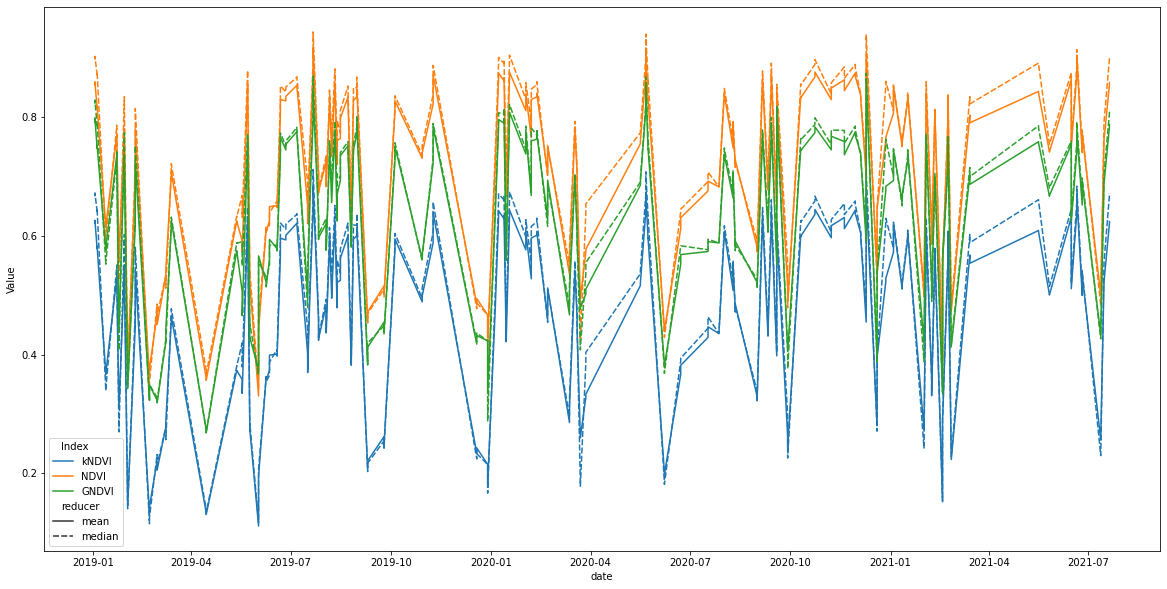

In [10]:
plt.figure(figsize = (20,10))
sns.lineplot(data = tsPandas_viz,
            x = 'date',
            y = 'Value',
            hue = 'Index',
            style = 'reducer')

In [11]:
df = tsPandas.set_index('date')
df

,GNDVI,NDVI,kNDVI,reducer
date,,,,
2019-01-02 15:41:29,0.799311,0.860169,0.626488,mean
2019-01-02 15:41:25,0.791848,0.855331,0.621576,mean
2019-01-04 15:31:35,0.752929,0.819072,0.582797,mean
2019-01-04 15:31:28,0.748128,0.815246,0.578904,mean
2019-01-12 15:41:31,0.579774,0.616436,0.368497,mean
...,...,...,...,...
2021-07-12 15:31:36,0.426418,0.483279,0.229403,median
2021-07-15 15:41:35,0.704641,0.792070,0.555921,median
2021-07-15 15:41:31,0.699510,0.788018,0.551804,median


In [12]:
month = pd.DataFrame()
for i in df.reducer.unique():
    M = df[df['reducer']== i]
    M = M.resample('M').mean()
    M['reducer'] = i
    month = month.append(M)
month.dropna(inplace=True)



In [13]:
tsPandas_viz = pd.melt(month.reset_index(),
                    id_vars = ['reducer','date'],
                    value_vars =vis,
                    var_name = 'Index',
                    value_name = 'Value')

<AxesSubplot:xlabel='date', ylabel='Value'>

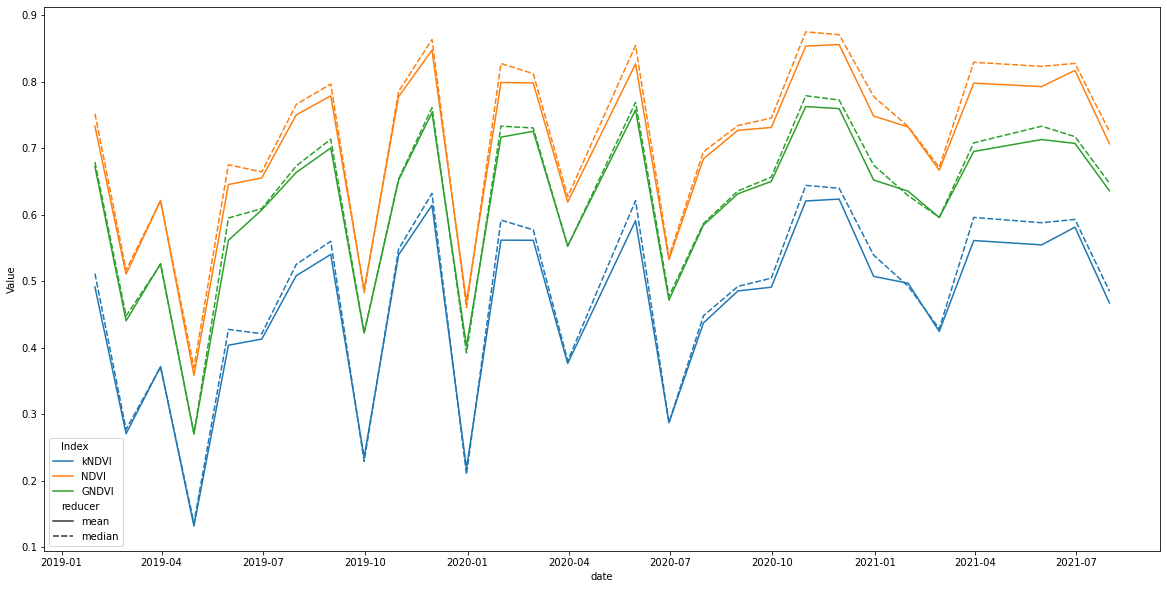

In [14]:
plt.figure(figsize = (20,10))
sns.lineplot(data = tsPandas_viz,
            x = 'date',
            y = 'Value',
            hue = 'Index',
            style = 'reducer')